### Import packages

In [559]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn import set_config
import warnings 
warnings.filterwarnings("ignore")
# Set the config so that we can view our preprocessor, and to transform output from numpy arrays to pandas dataframes
set_config(display="diagram")
set_config(transform_output="pandas")

### load data

In [560]:
df = pd.read_csv("data\housing_iteration_5_classification.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   TotalBsmtSF    1460 non-null   int64  
 3   BedroomAbvGr   1460 non-null   int64  
 4   Fireplaces     1460 non-null   int64  
 5   PoolArea       1460 non-null   int64  
 6   GarageCars     1460 non-null   int64  
 7   WoodDeckSF     1460 non-null   int64  
 8   ScreenPorch    1460 non-null   int64  
 9   Expensive      1460 non-null   int64  
 10  MSZoning       1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Heating        1460 non-null   object 
 13  Street         1460 non-null   object 
 14  CentralAir     1460 non-null   object 
 15  Foundation     1460 non-null   object 
 16  ExterQual      1460 non-null   object 
 17  ExterCond      1460 non-null   object 
 18  BsmtQual

### Data cleaning

In [561]:
df = df.set_index("Id")
df.shape

(1460, 80)

In [562]:
# Let's visualize missing values
missing_values_count = df.isnull().sum().sort_values(ascending=False)
missing_df = pd.DataFrame({'Column': missing_values_count.index, 'Missing Values': missing_values_count.values})

# Display the DataFrame
print(missing_df)

           Column  Missing Values
0          PoolQC            1453
1     MiscFeature            1406
2           Alley            1369
3           Fence            1179
4     FireplaceQu             690
..            ...             ...
75   YearRemodAdd               0
76      YearBuilt               0
77    OverallCond               0
78    OverallQual               0
79  SaleCondition               0

[80 rows x 2 columns]


In [563]:
missing_df.loc[missing_df["Column"]=="GarageCars"]

,Column,Missing Values
56,GarageCars,0


In [564]:
df = df.drop(["PoolQC", "MiscFeature", "Alley", "Fence"], axis=1)

In [565]:
df.head(3)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,...,HeatingQC,Electrical,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,8450,65.0,856,3,0,0,2,0,0,0,...,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,9600,80.0,1262,3,1,0,2,298,0,0,...,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,11250,68.0,920,3,1,0,2,0,0,0,...,Ex,SBrkr,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [566]:
df.columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'Expensive',
       'MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu',
       'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal',
       'MoSold', 'YrSold', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'BsmtFinTyp

In [567]:
labels = ['SoldBefore05', 'SoldBetween05-15', 'SoldAfter15']

# Define a custom function to assign categories based on the 'YrSold' values
def categorize_year_sold(year_sold):
    if year_sold < 2005:
        return labels[0]
    elif 2005 <= year_sold <= 2015:
        return labels[1]
    else:
        return labels[2]

# Apply the custom function to create the new categorical column
df['YrSold'] = df['YrSold'].apply(categorize_year_sold)
df['YrSold']

Id
1       SoldBetween05-15
2       SoldBetween05-15
3       SoldBetween05-15
4       SoldBetween05-15
5       SoldBetween05-15
              ...       
1456    SoldBetween05-15
1457    SoldBetween05-15
1458    SoldBetween05-15
1459    SoldBetween05-15
1460    SoldBetween05-15
Name: YrSold, Length: 1460, dtype: object

In [568]:
# Define a custom function to assign seasons based on the 'MoSold' values
def categorize_season(month_sold):
    if month_sold in [12, 1, 2]:
        return 'Winter'
    elif month_sold in [3, 4, 5]:
        return 'Spring'
    elif month_sold in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the custom function to create the new categorical column
df['MoSold'] = df['MoSold'].apply(categorize_season)

### Feature selection

In [569]:
df_cat = df.select_dtypes(exclude="number")
df_cat = df_cat.fillna(value="NaN")
df_cat = pd.get_dummies(df_cat, drop_first=True)

df_num = df.select_dtypes(include="number")
df_num = df_num.fillna(df_num.mean())

data = pd.concat([df_num, df_cat], axis=1)
X = data.drop("Expensive", axis=1)
y = data["Expensive"]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3)

sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]

print(len(selected_feat), selected_feat)
selected_features = ['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
                     'GarageCars', 'WoodDeckSF', 'MSSubClass', 'OverallQual', 'YearBuilt',
                     'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF',
                     '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'TotRmsAbvGrd', 'GarageYrBlt',
                     'GarageArea', 'OpenPorchSF', 'Foundation', 'ExterQual', 'BsmtQual',
                     'KitchenQual', 'FireplaceQu', 'Neighborhood', 'RoofStyle', 'MasVnrType', 'SaleType']

df = df[selected_features + ["Expensive"]]

41 Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'OpenPorchSF',
       'Foundation_CBlock', 'Foundation_PConc', 'ExterQual_Gd', 'ExterQual_TA',
       'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'KitchenQual_Gd',
       'KitchenQual_TA', 'FireplaceQu_Gd', 'FireplaceQu_NaN',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'RoofStyle_Gable',
       'RoofStyle_Hip', 'MasVnrType_None'],
      dtype='object')


### Split data

In [570]:
# Create train/test split
X = df.drop(["Expensive"], axis=1)
y = df["Expensive"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [571]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1314, 31) (146, 31) (1314,) (146,)


In [572]:
# Divide columns by data_types
X_train_cat = X_train.select_dtypes(exclude="number")
X_train_num = X_train.select_dtypes(include="number")

In [573]:
X_train_cat.describe()

,Foundation,ExterQual,BsmtQual,KitchenQual,FireplaceQu,Neighborhood,RoofStyle,MasVnrType,SaleType
count,1314,1314,1283,1314,706,1314,1314,1306,1314
unique,6,4,4,4,5,25,6,4,9
top,PConc,TA,TA,TA,Gd,NAmes,Gable,None,WD
freq,581,810,587,656,350,198,1028,775,1139


### Remove outliers

In [574]:
# Define IQRTransformer
class IQRTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=1.5):
        self.multiplier = multiplier
        self.num_outliers_removed = 0

    def fit(self, X, y=None):
        # Calculate the IQR for each feature
        self.lower_bound = np.percentile(X, 25, axis=0) - self.multiplier * np.subtract(*np.percentile(X, [75, 25], axis=0))
        self.upper_bound = np.percentile(X, 75, axis=0) + self.multiplier * np.subtract(*np.percentile(X, [75, 25], axis=0))
        return self

    def transform(self, X):
        # Count the number of outliers removed
        self.num_outliers_removed += np.sum((X < self.lower_bound) | (X > self.upper_bound))

        # Apply the IQR bounds to each feature
        X_transformed = np.clip(X, self.lower_bound, self.upper_bound)
        return X_transformed

### Create pipelines and column trasformers

In [575]:
# numerical pipeline: replace missing with mean
num_pipe = make_pipeline(SimpleImputer(strategy="mean"))

# categorical pipeline = "N_A" imputer + categorical encoder
categorical_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="NaN"),
                                 OneHotEncoder(sparse_output=False,handle_unknown='infrequent_if_exist',min_frequency=0.03))

full_preprocessing = ColumnTransformer(
    transformers=[
        ("num_pipe", num_pipe, X_train_num.columns),
        ("cat_pipe", categorical_pipe, X_train_cat.columns),
    ]
)

full_preprocessing

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'MSSubClass', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'TotRmsAbvGrd'...
                                ('cat_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NaN',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.03,
                                                                sparse_output=False))]),
                                 Index(['Foundation', 'ExterQual', 'BsmtQual', 'KitchenQual', 'FireplaceQu',
       'Neighborhood', 'RoofStyle', 'MasVnrType', 'SaleType'],
      dtype='object'))])

In [576]:
# Visualize the pipeline
full_pipeline_Dtree = make_pipeline(full_preprocessing,
                                         IQRTransformer(),
                                         StandardScaler(),
                                         DecisionTreeClassifier())
full_pipeline_Dtree.fit(X_train,y_train)
print(full_pipeline_Dtree.named_steps.columntransformer)
print(full_pipeline_Dtree.named_steps.columntransformer.named_transformers_["num_pipe"].named_steps.simpleimputer.get_feature_names_out())

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'MSSubClass', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'TotRmsAbvGrd'...
                                ('cat_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NaN',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                      

### Try different models

#### DecisionTreeClassifier

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
{'columntransformer__num_pipe__simpleimputer__strategy': 'most_frequent', 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__min_samples_leaf': 3, 'standardscaler__with_mean': False, 'standardscaler__with_std': False} {'dtree_iqr': 0.9391112530113489}
0.9315068493150684


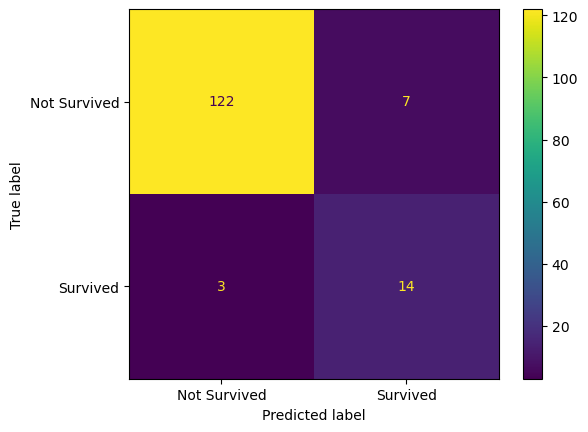

In [534]:
# Full pipeline: preprocessor + model
full_pipeline_Dtree_iqr = make_pipeline(full_preprocessing,
                                         IQRTransformer(),
                                         StandardScaler(),
                                         DecisionTreeClassifier())

# Define parameter grid
param_grid_iqr = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median", "most_frequent"],
    "standardscaler__with_mean":[True, False],
    "standardscaler__with_std":[True, False],
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2),
    "decisiontreeclassifier__criterion": ["gini", "entropy", "log_loss"],
}

# Define GridSearchCV
search_dtree_iqr = GridSearchCV(full_pipeline_Dtree_iqr,
                                param_grid_iqr,
                                cv=5,
                                verbose=1)

search_dtree_iqr.fit(X_train, y_train)


# Create a dictionary to store the best scores from the different models
scores = {"dtree_iqr": search_dtree_iqr.best_score_}

best_param = search_dtree_iqr.best_params_

print(best_param, scores)

# Test accuracy
print(accuracy_score(search_dtree_iqr.predict(X_test), y_test))

# Plot confusion matrix
print(ConfusionMatrixDisplay.from_estimator(search_dtree_iqr,
                                             X_test,
                                             y_test,
                                             display_labels=['Not Survived', 'Survived']))


#### KNNClassifier

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'columntransformer__num_pipe__simpleimputer__strategy': 'mean', 'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__weights': 'distance', 'standardscaler__with_mean': True, 'standardscaler__with_std': True} {'dtree_iqr': 0.9391112530113489, 'knn_iqr': 0.944440251937422}
0.958904109589041


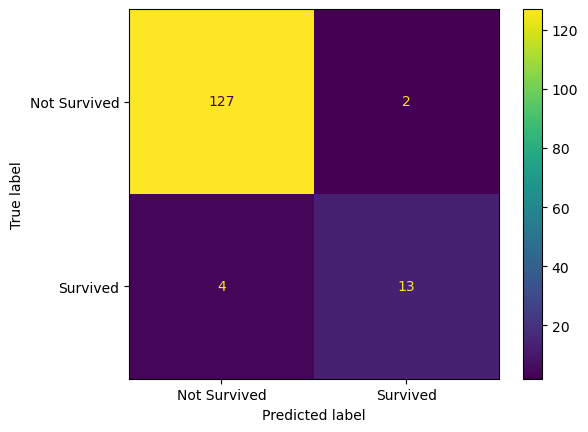

In [535]:
# Full pipeline: preprocessor + model
full_pipeline_knn_iqr = make_pipeline(full_preprocessing,
                                         IQRTransformer(),
                                         StandardScaler(),
                                         KNeighborsClassifier())

# Define parameter grid
param_grid_knn = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median", "most_frequent"],
    "standardscaler__with_mean":[True, False],
    "standardscaler__with_std":[True, False],
    "kneighborsclassifier__n_neighbors": range(2, 50, 2),
    "kneighborsclassifier__weights": ["uniform", "distance"],
}

# Define GridSearchCV
search_knn_iqr = GridSearchCV(full_pipeline_knn_iqr,
                                param_grid_knn,
                                cv=5,
                                verbose=1)

search_knn_iqr.fit(X_train, y_train)


# Create a dictionary to store the best scores from the different models
scores["knn_iqr"]= search_knn_iqr.best_score_

best_param = search_knn_iqr.best_params_

print(best_param, scores)

# Test accuracy
print(accuracy_score(search_knn_iqr.predict(X_test), y_test))

# Plot confusion matrix
print(ConfusionMatrixDisplay.from_estimator(search_knn_iqr,
                                             X_test,
                                             y_test,
                                             display_labels=['Not Survived', 'Survived']))

#### Logistic regression

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'columntransformer__num_pipe__simpleimputer__strategy': 'median', 'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'standardscaler__with_mean': True, 'standardscaler__with_std': True} {'dtree_iqr': 0.9391112530113489, 'knn_iqr': 0.944440251937422, 'lr_iqr': 0.9505355121469827}
0.9657534246575342


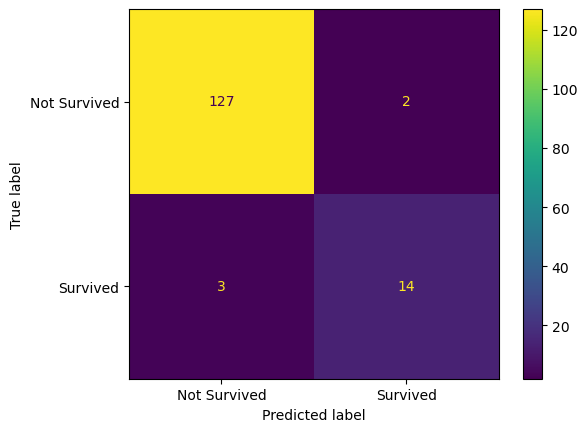

In [536]:
# Full pipeline: preprocessor + model
full_pipeline_lr_iqr = make_pipeline(full_preprocessing,
                                         IQRTransformer(),
                                         StandardScaler(),
                                         LogisticRegression(max_iter=1000, solver='saga', tol=0.1))

# Define parameter grid
param_grid_lr = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median", "most_frequent"],
    "standardscaler__with_mean":[True, False],
    "standardscaler__with_std":[True, False],
    'logisticregression__C': [0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2']
}

# Define GridSearchCV
search_lr = GridSearchCV(full_pipeline_lr_iqr,
                                param_grid_lr,
                                cv=5,
                                verbose=1)

search_lr.fit(X_train, y_train)


# Create a dictionary to store the best scores from the different models
scores["lr_iqr"]= search_lr.best_score_

best_param = search_lr.best_params_

print(best_param, scores)

# Test accuracy
print(accuracy_score(search_lr.predict(X_test), y_test))

# Plot confusion matrix
print(ConfusionMatrixDisplay.from_estimator(search_lr,
                                             X_test,
                                             y_test,
                                             display_labels=['Not Survived', 'Survived']))

#### RandomForestClassifier

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
{'columntransformer__num_pipe__simpleimputer__strategy': 'mean', 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 8, 'standardscaler__with_mean': False, 'standardscaler__with_std': False} {'dtree_iqr': 0.9391112530113489, 'knn_iqr': 0.944440251937422, 'lr_iqr': 0.9505355121469827, 'rf_iqr': 0.954329086001219}
0.952054794520548


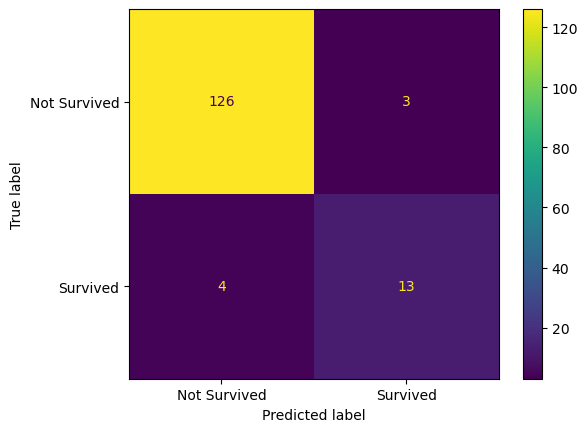

In [537]:
# Full pipeline: preprocessor + model
full_pipeline_rf_iqr = make_pipeline(full_preprocessing,
                                         IQRTransformer(),
                                         StandardScaler(),
                                         RandomForestClassifier())

# Define parameter grid
param_grid_rf = {"columntransformer__num_pipe__simpleimputer__strategy":["mean", "median", "most_frequent"],
                 "standardscaler__with_mean":[True, False],
                 "standardscaler__with_std":[True, False],
                 'randomforestclassifier__max_depth': list(range(15, 35, 5)), 
                 'randomforestclassifier__max_features': list(range(3,10))}


# Define GridSearchCV
search_rf = GridSearchCV(full_pipeline_rf_iqr,
                                param_grid_rf,
                                cv=5,
                                verbose=1)

search_rf.fit(X_train, y_train)


# Create a dictionary to store the best scores from the different models
scores["rf_iqr"]= search_rf.best_score_

best_param = search_rf.best_params_

print(best_param, scores)

# Test accuracy
print(accuracy_score(search_rf.predict(X_test), y_test))

# Plot confusion matrix
print(ConfusionMatrixDisplay.from_estimator(search_rf,
                                             X_test,
                                             y_test,
                                             display_labels=['Not Survived', 'Survived']))

#### SVC

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'columntransformer__num_pipe__simpleimputer__strategy': 'most_frequent', 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
0.9657534246575342


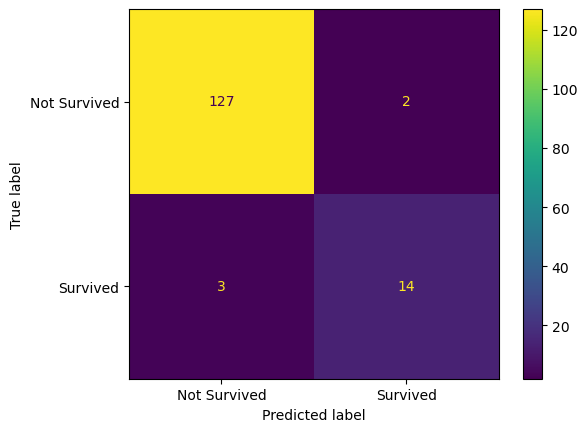

In [538]:
# Full pipeline: preprocessor + model
full_pipeline_svc_iqr = make_pipeline(full_preprocessing,
                                         IQRTransformer(),
                                         StandardScaler(),
                                         SVC())

# Define parameter grid
param_grid_svc = {"columntransformer__num_pipe__simpleimputer__strategy":["mean", "median", "most_frequent"],
                 "standardscaler__with_mean":[True, False],
                 "standardscaler__with_std":[True, False],
                  'svc__C': [0.1, 1, 10, 100, 1000],  
                  'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                  'svc__kernel': ['rbf']}  

# Define GridSearchCV
search_svc = GridSearchCV(full_pipeline_svc_iqr,
                                param_grid_svc,
                                cv=5,
                                verbose=1)

search_svc.fit(X_train, y_train)


# Create a dictionary to store the best scores from the different models
scores["svc_iqr"]= search_svc.best_score_

best_param = search_svc.best_params_

print(best_param)

# Test accuracy
print(accuracy_score(search_svc.predict(X_test), y_test))

# Plot confusion matrix
print(ConfusionMatrixDisplay.from_estimator(search_svc,
                                             X_test,
                                             y_test,
                                             display_labels=['Not Survived', 'Survived']))

In [539]:
scores

{'dtree_iqr': 0.9391112530113489,
 'knn_iqr': 0.944440251937422,
 'lr_iqr': 0.9505355121469827,
 'rf_iqr': 0.954329086001219,
 'svc_iqr': 0.9505297071372596}

### Test the competition data with the best model

In [540]:
#loading the new test data for the competition
url = "https://drive.google.com/file/d/1HMsEK5Kq7CcGFz7_GyQyI4ziEr3iAu8x/view?usp=drive_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
competition_test = pd.read_csv(path)

In [541]:
Id = competition_test.pop("Id")

# Restrict the columns
competition_test = competition_test[selected_features]

In [558]:
# make predictions with the brand new (unlabelled) dataset for the competition!
submission_prediction = search_rf.predict(competition_test)
submission_prediction = list(submission_prediction)

# Create the Dataframe for the submission. It must contain two columns: "Id" and "Expensive"
submission_df = pd.DataFrame()
submission_df['Id'] = Id
submission_df['Expensive'] = submission_prediction

# create the csv for the competition and download it
submission_df.to_csv("classification_competition_predictions.csv", index=False)